In [ ]:
# !pip install diffusers==0.3.0

In [ ]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [ ]:
# !pip install torch

In [1]:
from diffusers import DDPMPipeline

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
image_pipe.to("cpu")

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.3.0",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [4]:
images = image_pipe().images

  0%|          | 0/1000 [00:00<?, ?it/s]

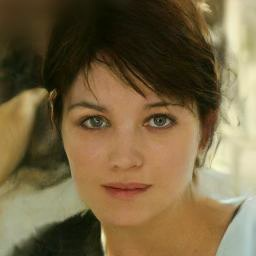

In [5]:
images[0]

In [6]:
from diffusers import UNet2DModel

In [7]:
repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

C:\Users\Richard\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Richard\.cache\huggingface\diffusers. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [8]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (c

In [9]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [10]:
model_random = UNet2DModel(**model.config)

In [11]:
model_random.save_pretrained("my_model")

In [13]:
model_random = UNet2DModel.from_pretrained("my_model")

In [14]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [15]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

In [16]:
noisy_residual.shape

torch.Size([1, 3, 256, 256])

In [17]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

In [18]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.3.0')])

In [19]:
scheduler.save_config("my_scheduler")
new_scheduler = DDPMScheduler.from_config("my_scheduler")

In [20]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [21]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [22]:
model.to("cpu")

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (c

In [23]:
noisy_sample = noisy_sample.to("cpu")

  5%|███▉                                                                            | 49/1000 [02:04<40:34,  2.56s/it]

'Image at step 50'

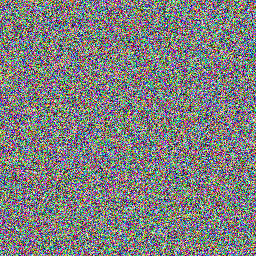

 10%|███████▉                                                                        | 99/1000 [04:10<38:05,  2.54s/it]

'Image at step 100'

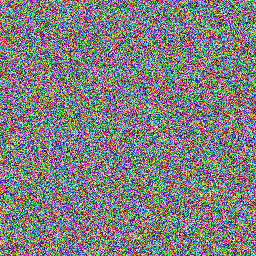

 15%|███████████▊                                                                   | 149/1000 [06:18<35:35,  2.51s/it]

'Image at step 150'

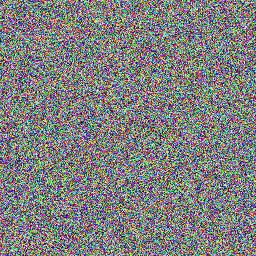

 20%|███████████████▋                                                               | 199/1000 [08:39<37:01,  2.77s/it]

'Image at step 200'

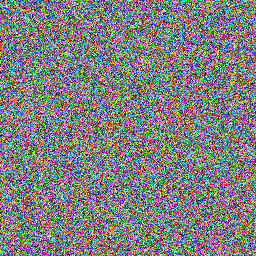

 25%|███████████████████▋                                                           | 249/1000 [10:59<33:02,  2.64s/it]

'Image at step 250'

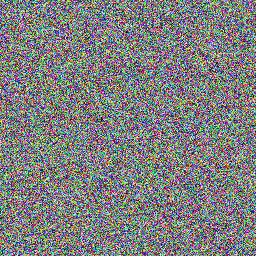

 30%|███████████████████████▌                                                       | 299/1000 [13:21<32:51,  2.81s/it]

'Image at step 300'

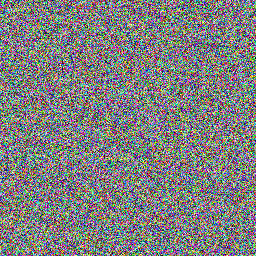

 35%|███████████████████████████▌                                                   | 349/1000 [15:37<30:14,  2.79s/it]

'Image at step 350'

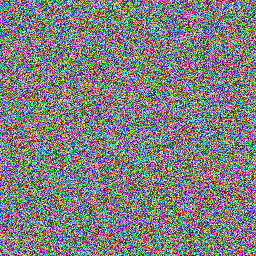

 40%|███████████████████████████████▌                                               | 399/1000 [17:51<25:42,  2.57s/it]

'Image at step 400'

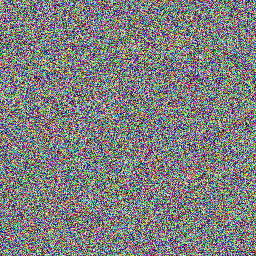

 45%|███████████████████████████████████▍                                           | 449/1000 [20:10<25:09,  2.74s/it]

'Image at step 450'

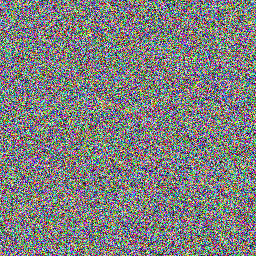

 50%|███████████████████████████████████████▍                                       | 499/1000 [22:29<22:17,  2.67s/it]

'Image at step 500'

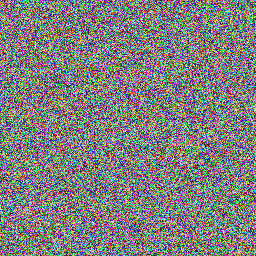

 55%|███████████████████████████████████████████▎                                   | 549/1000 [24:46<20:53,  2.78s/it]

'Image at step 550'

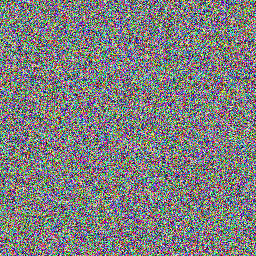

 60%|███████████████████████████████████████████████▎                               | 599/1000 [26:55<19:10,  2.87s/it]

'Image at step 600'

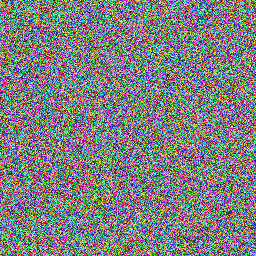

 65%|███████████████████████████████████████████████████▎                           | 649/1000 [29:11<16:14,  2.78s/it]

'Image at step 650'

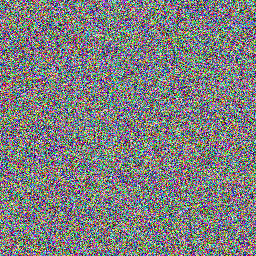

 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [31:32<13:58,  2.79s/it]

'Image at step 700'

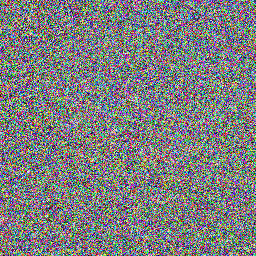

 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [33:58<11:54,  2.85s/it]

'Image at step 750'

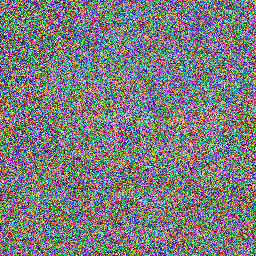

 80%|███████████████████████████████████████████████████████████████                | 799/1000 [36:26<09:50,  2.94s/it]

'Image at step 800'

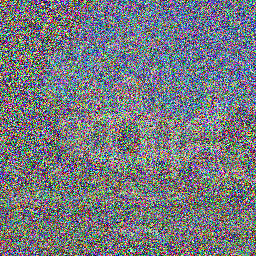

 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [38:48<06:47,  2.70s/it]

'Image at step 850'

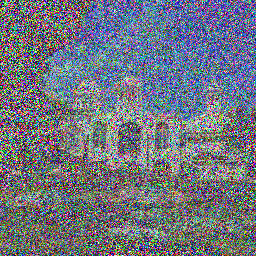

 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [41:09<05:02,  2.99s/it]

'Image at step 900'

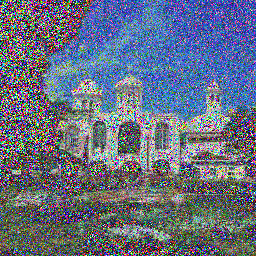

 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [43:22<02:10,  2.55s/it]

'Image at step 950'

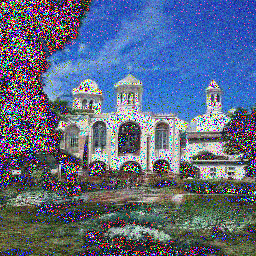

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [45:32<00:02,  2.65s/it]

'Image at step 1000'

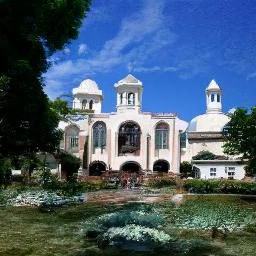

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:35<00:00,  2.74s/it]


In [24]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)